# Machine Learning

> We've got numerical vectors, why not use ML?

In [4]:
#| default_exp machine_learning

## Setup

In [92]:
#| export
import xgboost
from pathlib import Path
import numpy as np
import pandas as pd
import json
from langchain.document_loaders import DataFrameLoader
from langchain.schema import Document
from tqdm import tqdm
from google.cloud import storage
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.utils import class_weight
from matplotlib import pyplot as plt

from classifier.schema import get_storage_client
from classifier.load import PROJECT_BUCKET, WRITE_PREFIX, \
    get_training_instances, get_idx
from classifier.chroma import read_json_lines_from_gcs, get_embedder, get_document_batches

## Load data

In [6]:
summary_embedding_path = "summarization_embeddings.json"
summary_metadata_path = "summarization_metadata.jsonl"
summary_path = "summarization/prediction-model-2023-12-18T15:10:57.834767Z/000000000000.jsonl"

Get summaries

In [7]:
summaries_jsonl = list(read_json_lines_from_gcs(f"{WRITE_PREFIX}/{summary_path}"))

In [8]:
summaries_jsonl[0]['predictions'][0].get('content')

' The email is from Max Daugherty, Vice President of Clinical Operations at Partners Pharmacy. He is requesting a same-day order for account number 2057192443 in Stafford, TX. The confirmation number for the order is 1053194086.\n\nThe customer is requesting that the order be removed from credit hold, processed, and delivered to the pharmacy the same day.'

In [9]:
summaries = pd.Series([s.get('predictions',[{}])[0].get('content', "").strip() for s in summaries_jsonl])
summaries.str.len().describe()

count    10000.000000
mean       258.840000
std        107.561965
min          0.000000
25%        216.000000
50%        275.000000
75%        323.000000
max        578.000000
dtype: float64

Get metadata

In [10]:
summary_metadata = list(read_json_lines_from_gcs(
    f"{WRITE_PREFIX}/{summary_metadata_path}"
))

Combine

In [11]:
summary_dataframe = pd.DataFrame.from_records(summary_metadata)
summary_dataframe.loc[:, 'summary'] = summaries
summary_dataframe.set_index('idx', inplace=True)
summary_dataframe = summary_dataframe[summary_dataframe.summary.str.len() > 0]
summary_dataframe.head(2)

,BU,case_number,ACCOUNT_BUSINESS_UNIT__C,received_at,sfdc_subcategory,predicted_category,predicted_subcategory,record_type,probability,Accuracy_upd,Bin,summary
idx,,,,,,,,,,,,
48942,PD,3665915,NaN,2023-12-01T22:43:59,Inquiry,Order Processing,Order Entry,1,0.676467,Incorrect,6,"The email is from Max Daugherty, Vice Presiden..."
37242,PD,3622254,NaN,2023-11-13T16:16:55,Account updates,Account/Inquiry,NaN,1,0.764455,Correct,7,"The customer, Nicholas Brand from Slavins Hanc..."


Get labels from source

In [12]:
# Add label
training_data = pd.DataFrame(
    [
        i.to_series() for i in list(
            get_training_instances(
                index_prefix=f"{WRITE_PREFIX}/summarization_idx"
            ))]
).set_index('idx')
training_data.head(2)

,BU,case_number,ACCOUNT_BUSINESS_UNIT__C,received_at,sfdc_subcategory,predicted_category,predicted_subcategory,record_type,probability,Accuracy_upd,Bin,label,email_subject,email_body
idx,,,,,,,,,,,,,,
35913,NaN,3616412,a1G4z00000H6hxdEAB,2023-11-09T16:57:08,Pricing Issue,General Inquiry,NaN,3,0.499070,Incorrect,4,Pricing,General Inquiry -2052030981 -Other,Case Category: General Inquiry Case Sub-Catego...
48645,PD,3665065,a1G4z00000H4sDsEAJ,2023-12-01T19:21:56,Drop Ship Order,Order Processing,Drop Ship Order,1,0.917244,Correct,9,Order Processing,Drop Ship Order,External Email â€“ Please use caution before o...


Get train, test idx

In [13]:
train_idx, test_idx = get_idx(prefix=f"{WRITE_PREFIX}/summarization_idx")

In [14]:
train_idx.shape, test_idx.shape

((7418,), (1857,))

In [15]:
summary_dataframe.loc[:, 'label'] = training_data.label
summary_dataframe.loc[:, 'email_body'] = training_data.email_body
summary_dataframe.loc[:, 'email_subject'] = training_data.email_subject
summary_dataframe.label.isna().value_counts()

label
False    9275
Name: count, dtype: int64

In [16]:
summary_dataframe.head(2)

,BU,case_number,ACCOUNT_BUSINESS_UNIT__C,received_at,sfdc_subcategory,predicted_category,predicted_subcategory,record_type,probability,Accuracy_upd,Bin,summary,label,email_body,email_subject
idx,,,,,,,,,,,,,,,
48942,PD,3665915,NaN,2023-12-01T22:43:59,Inquiry,Order Processing,Order Entry,1,0.676467,Incorrect,6,"The email is from Max Daugherty, Vice Presiden...",Order Processing,External Email â€“ Please use caution before o...,PO 70026263
37242,PD,3622254,NaN,2023-11-13T16:16:55,Account updates,Account/Inquiry,NaN,1,0.764455,Correct,7,"The customer, Nicholas Brand from Slavins Hanc...",Account/Inquiry,External Email â€“ Please use caution before o...,Sent - Invoice 7334254502 - to State of Florid...


Get Embeddings

In [17]:
with get_storage_client().bucket(PROJECT_BUCKET).blob(f"{WRITE_PREFIX}/{summary_embedding_path}").open('r') as f:
    summary_embeddings = json.load(f)

In [18]:
train_idx.shape

(7418,)

In [19]:
X_train = pd.DataFrame(summary_embeddings, index=train_idx.values)
X_train.head(2)

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
35913,0.015652,-0.009372,-0.018316,-0.036093,0.026927,0.020672,-0.005812,-0.064976,0.006214,0.040197,...,0.033278,0.009020,-0.03424,0.016257,-0.061142,0.025347,0.057820,0.015422,-0.013001,-0.007241
48645,0.013315,-0.016115,-0.046833,0.023515,0.029719,0.011179,0.053018,-0.035807,0.029324,0.080764,...,0.040658,0.011668,-0.01131,0.041687,-0.078796,-0.002770,-0.027495,0.014569,-0.048885,0.033022


In [20]:
# Embed test summaries
embedder = get_embedder()

In [30]:
X_test_documents = DataFrameLoader(summary_dataframe.loc[test_idx.values.tolist(), :], 'summary').load()
assert len(X_test_documents) == test_idx.shape[0] and isinstance(X_test_documents[0], Document)

In [34]:
pbar = tqdm(total=len(X_test_documents), ncols=80, leave=False)

X_test_embeddings = []

for d_batch in get_document_batches(iter(X_test_documents), 5):
    d_batch_embeddings = embedder.embed_documents([d.page_content for d in d_batch])
    X_test_embeddings.extend(d_batch_embeddings)
    pbar.update(len(d_batch))

pbar.close()

In [35]:
X_test = pd.DataFrame(X_test_embeddings, index=test_idx.values)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
37508,0.025763,-0.043358,-0.059988,-0.006510,0.050462,0.031072,0.026154,-0.031391,0.004362,0.079660,...,0.039524,0.016611,-0.009875,0.037415,-0.088915,-0.003033,-0.009822,0.008075,-0.027388,0.036531
1092,0.010212,-0.065601,-0.046643,-0.026324,0.025507,-0.019755,0.020193,-0.028189,-0.032889,0.078821,...,0.027265,0.064589,0.007892,0.038051,-0.027449,0.048136,-0.012972,0.042120,-0.014899,0.023487
33786,-0.010943,-0.024541,-0.054613,0.000559,0.055305,-0.018420,-0.035239,-0.058743,0.012717,0.053802,...,0.046504,-0.008463,-0.026734,0.007011,-0.055340,0.039080,0.026713,-0.011966,-0.027616,0.026608
20135,-0.028766,-0.071089,-0.057118,-0.043357,0.012726,-0.013878,0.003694,-0.021237,0.004773,0.060014,...,0.018917,0.014239,-0.015978,0.011922,-0.022765,0.037982,-0.028093,0.044119,-0.035519,0.057812
29323,-0.009519,-0.015032,-0.011268,-0.033827,-0.014799,0.019384,0.015864,-0.061485,0.038982,0.085399,...,0.040118,0.029670,-0.005780,0.042032,-0.061004,0.022132,-0.045787,0.027441,-0.007872,0.026882


Get train, test split

In [36]:
X_train.shape, X_test.shape

((7418, 768), (1857, 768))

In [40]:
label_encoder = LabelEncoder().fit(summary_dataframe.label)

In [41]:
y_train, y_test = label_encoder.transform(summary_dataframe.loc[train_idx.values, 'label']), \
    label_encoder.transform(summary_dataframe.loc[test_idx.values, 'label'])
y_train.shape, y_test.shape

((7418,), (1857,))

In [42]:
d_train = xgboost.DMatrix(X_train, y_train)
d_test = xgboost.DMatrix(X_test, y_test)

## Train model

In [95]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [97]:
class_weight.compute_class_weight()

TypeError: compute_class_weight() missing 1 required positional argument: 'class_weight'

In [98]:
class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)

array([ 0.42600356,  2.31740081,  5.76379176,  2.76378539,  0.94053506,
        1.33802309,  0.22463812, 20.43526171,  1.68590909, 20.43526171,
        1.36510858])

In [101]:
xgb_params = {
    "max_depth": 2, 
    "eta": 1, 
    "objective": "multi:softmax", 
    'num_class': label_encoder.classes_.shape[0],
    'sample_weight': list(
        class_weight.compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train))
    }
watchlist = [(d_test, "eval"), (d_train, "train")]
num_round = 5

In [102]:
bst = xgboost.train(xgb_params, d_train, num_boost_round=num_round, evals=watchlist)

/Users/jake.bergren/Documents/20-29 Projects/23 Customer Service Projects/23.01 2023 Email Classification/customer_service_email_classification/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [12:17:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "sample_weight" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	eval-mlogloss:1.89940	train-mlogloss:1.86061
[1]	eval-mlogloss:1.85459	train-mlogloss:1.77921
[2]	eval-mlogloss:1.84633	train-mlogloss:1.73709
[3]	eval-mlogloss:1.84143	train-mlogloss:1.70652
[4]	eval-mlogloss:1.84276	train-mlogloss:1.68248


In [103]:
# run prediction
preds = bst.predict(d_test)
labels = d_test.get_label()
print(
    "error=%f"
    % (
        sum(1 for i in range(len(preds)) if int(preds[i] > 0.5) != labels[i])
        / float(len(preds))
    )
)

error=0.945611


Save

In [104]:
data_dir = Path("../data")
assert data_dir.exists()
xgb_dir = data_dir / 'xgboost'
if not xgb_dir.exists():
    xgb_dir.mkdir()

In [105]:
bst.save_model(xgb_dir / "model-0.json")
# dump model
bst.dump_model(xgb_dir / "dump.raw.txt")

# save dmatrix into binary buffer
d_test.save_binary(xgb_dir / "dtest.dmatrix")
# save model
bst.save_model(xgb_dir / "model-1.json")

## Evaluate predictions

In [106]:
preds

array([6., 0., 6., ..., 6., 6., 6.], dtype=float32)

In [107]:
predictions = pd.Series(label_encoder.inverse_transform(preds.astype(int)))
predictions.value_counts()

Order Processing     1670
Account/Inquiry       136
General Inquiry        19
Product Inquiry        10
Returns                10
Order Discrepancy      10
Delivery                2
Name: count, dtype: int64

In [108]:
metrics.accuracy_score(y_test, preds)

0.37964458804523427

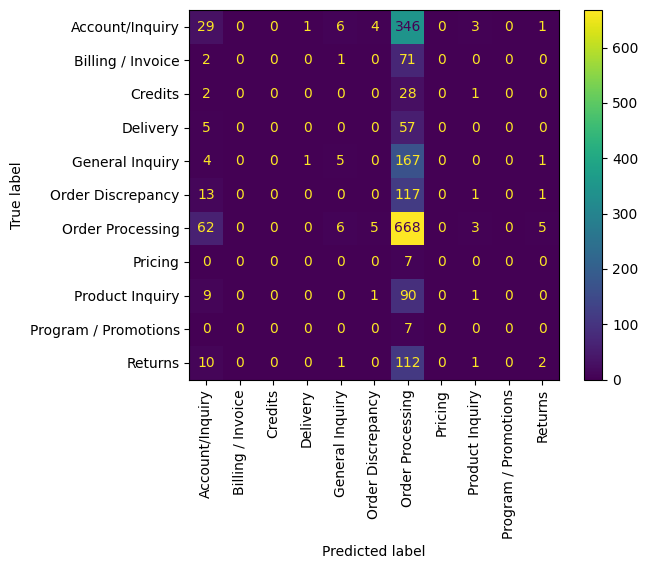

In [109]:
conf_display = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, preds)).plot()
plt.xticks(conf_display.ax_.get_xticks(), labels=label_encoder.classes_, rotation=90)
plt.yticks(conf_display.ax_.get_yticks(), labels=label_encoder.classes_)
plt.show()

## Export

In [110]:
#| hide
import nbdev;nbdev.nbdev_export()